# Paper Metrics & Plots from Saved Predictions (.npz)

This notebook generates common scientific metrics and figures from exported prediction files produced by your evaluation pipeline.

**Inputs (expected in `eval_dir`)**:
- `internal_preds_ensemble.npz` or `internal_preds_fold_*.npz`
- `external_preds_ensemble.npz` or `external_preds_fold_*.npz`

Each `.npz` should contain:
- `y_true` (0/1)
- `y_prob` (probability of class 1 = **lung**)

**Outputs (written to `out_dir`)**:
- Confusion matrix PNG
- ROC curve PNG
- PR curve PNG
- Calibration curve PNG
- `*_paper_metrics.json`
- `*_predictions.csv` with `lung/non_lung` labels
- `*_curves.npz` with curve points


In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys

# Class name mapping (0/1 -> string labels)
CLASS_NAMES = {0: "non_lung", 1: "lung"}


In [2]:
def load_npz(npz_path: Path):
    d = np.load(npz_path)
    y_true = d["y_true"].astype(int).reshape(-1)
    y_prob = d["y_prob"].astype(float).reshape(-1)
    return y_true, y_prob


def confusion_from_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, tn, fp, fn


def basic_metrics(y_true, y_prob, thr=0.5):
    tp, tn, fp, fn = confusion_from_threshold(y_true, y_prob, thr)
    n = tp + tn + fp + fn

    acc = (tp + tn) / max(n, 1)
    sens = tp / max(tp + fn, 1)  # recall, TPR
    spec = tn / max(tn + fp, 1)  # TNR
    prec = tp / max(tp + fp, 1)
    f1 = (2 * prec * sens) / max(prec + sens, 1e-12)
    bal_acc = 0.5 * (sens + spec)

    # Matthews correlation coefficient (MCC)
    denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = ((tp * tn) - (fp * fn)) / denom if denom > 0 else 0.0

    return {
        "n": int(n),
        "threshold": float(thr),
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "accuracy": float(acc),
        "balanced_accuracy": float(bal_acc),
        "sensitivity_recall": float(sens),
        "specificity": float(spec),
        "precision": float(prec),
        "f1": float(f1),
        "mcc": float(mcc),
    }


def roc_curve_manual(y_true, y_prob, num=500):
    thresholds = np.linspace(1.0, 0.0, num=num)
    tpr = np.zeros_like(thresholds)
    fpr = np.zeros_like(thresholds)

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    for i, thr in enumerate(thresholds):
        tp, tn, fp, fn = confusion_from_threshold(y_true, y_prob, thr)
        tpr[i] = tp / max(P, 1)
        fpr[i] = fp / max(N, 1)

    order = np.argsort(fpr)
    fpr_s = fpr[order]
    tpr_s = tpr[order]
    auc = float(np.trapezoid(tpr_s, fpr_s))
    return fpr_s, tpr_s, thresholds, auc


def pr_curve_manual(y_true, y_prob, num=500):
    thresholds = np.linspace(1.0, 0.0, num=num)
    precision = np.zeros_like(thresholds)
    recall = np.zeros_like(thresholds)

    P = np.sum(y_true == 1)

    for i, thr in enumerate(thresholds):
        tp, tn, fp, fn = confusion_from_threshold(y_true, y_prob, thr)
        precision[i] = tp / max(tp + fp, 1)
        recall[i] = tp / max(P, 1)

    order = np.argsort(recall)
    r = recall[order]
    p = precision[order]
    ap = float(np.trapezoid(p, r))
    return r, p, thresholds, ap


def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true) ** 2))


def calibration_curve(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    frac_pos = []
    mean_pred = []
    counts = []

    for b in range(n_bins):
        mask = bin_ids == b
        if np.sum(mask) == 0:
            continue
        counts.append(int(np.sum(mask)))
        frac_pos.append(float(np.mean(y_true[mask])))
        mean_pred.append(float(np.mean(y_prob[mask])))

    return np.array(mean_pred), np.array(frac_pos), np.array(counts)


In [3]:
def save_confusion_matrix_plot(tp, tn, fp, fn, out_png: Path, title: str):
    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)

    fig = plt.figure(figsize=(4.8, 4.2))
    ax = plt.gca()
    ax.imshow(cm)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred non_lung", "Pred lung"])
    ax.set_yticklabels(["True non_lung", "True lung"])
    ax.set_title(title)

    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")

    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


def save_roc_plot(fpr, tpr, auc, out_png: Path, title: str):
    fig = plt.figure(figsize=(5.2, 4.2))
    ax = plt.gca()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{title} (AUC={auc:.3f})")
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


def save_pr_plot(recall, precision, ap, out_png: Path, title: str):
    fig = plt.figure(figsize=(5.2, 4.2))
    ax = plt.gca()
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{title} (AP={ap:.3f})")
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


def save_calibration_plot(mean_pred, frac_pos, out_png: Path, title: str):
    fig = plt.figure(figsize=(5.2, 4.2))
    ax = plt.gca()
    ax.plot(mean_pred, frac_pos, marker="o")
    ax.plot([0, 1], [0, 1])
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


In [4]:
def load_split_predictions(eval_dir: Path, split: str, use: str = "ensemble"):
    if use == "ensemble":
        npz = eval_dir / f"{split}_preds_ensemble.npz"
        y_true, y_prob = load_npz(npz)
        label = f"{split} ensemble"
    else:
        files = sorted(eval_dir.glob(f"{split}_preds_fold_*.npz"))
        if not files:
            raise FileNotFoundError(f"No fold files found for {split} in {eval_dir}")
        probs = []
        y_true = None
        for f in files:
            yt, yp = load_npz(f)
            if y_true is None:
                y_true = yt
            probs.append(yp)
        y_prob = np.mean(np.stack(probs, axis=0), axis=0)
        label = f"{split} mean-over-folds"
    return y_true, y_prob, label

## Runs

In [5]:
path_to_evals = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26")

runs = [f for f in path_to_evals.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {
    r.name.removeprefix("lung_vs_nolung_2cls_"): r
    for r in runs
}

print("Found runs:")
runs_dict

Found runs:


{'t1c_fine_resnet152_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_fine_resnet152_22_02_2026'),
 't1c_scratch_resnet34_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_resnet34_22_02_2026'),
 't1c_scratch_inceptionv3_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_inceptionv3_22_02_2026'),
 'maxinfo_scratch_resnext101_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_maxinfo_scratch_resnext101_23_02_2026'),
 't1c_rough_resnext50_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_le

In [6]:
OUT_ROOT = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Metrics")

use = "ensemble"
threshold = 0.5

In [32]:
import re
import json
from pathlib import Path
import pandas as pd
import numpy as np

# Where the evaluation run folders live (your existing path)
path_to_evals = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26")

runs = [f for f in path_to_evals.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {r.name.removeprefix("lung_vs_nolung_2cls_"): r for r in runs}

def parse_strategy(run: str):
    r = run.lower()
    # robust: look for whole tokens to avoid accidental matches
    # your runs contain "..._scratch_..." / "..._rough_..." / "..._fine_..."
    if re.search(r"(^|_)scratch(_|$)", r):
        return "scratch"
    if re.search(r"(^|_)rough(_|$)", r):
        return "rough"
    if re.search(r"(^|_)fine(_|$)", r):
        return "fine"
    return None

def apply_label_map(labels, label_map=None):
    """
    label_map example:
      {"t1c": "T1CE", "4 seq": "4 sequences", "clinical": "+clinical", "max_info": "max input"}
      {"scratch": "Scratch", "rough": "Rough pretraining", "fine": "Fine pretraining"}
    """
    if label_map is None:
        return [str(x) for x in labels]
    return [label_map.get(str(x), str(x)) for x in labels]

def parse_arch(run: str):
    r = run.lower()
    if "resnext101" in r:
        return "ResNeXt101"
    if "resnext50" in r:
        return "ResNeXt50"
    if "resnet152" in r:
        return "ResNet152"
    return None

def parse_input_variant(run: str):
    r = run.lower()

    if r.startswith("4seq"):
        return "4 seq"
    if r.startswith("t1c_clin"):
        return "clinical"
    if r.startswith("maxinfo"):
        return "max_info"
    if r.startswith("t1c"):
        return "t1c"

    return None

def format_auc_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

# metrics you want to plot (these exist in your JSON example)
metrics = ["auc", "accuracy", "f1", "sensitivity", "specificity", "mcc"]

rows = []

for run, run_path in runs_dict.items():
    arch = parse_arch(run)
    if arch not in ["ResNeXt50", "ResNeXt101", "ResNet152"]:
        continue

    variant = parse_input_variant(run)
    if variant is None:
        continue

    for split in ["internal", "external"]:
        json_path = run_path / f"{split}_ensemble.json"
        if not json_path.exists():
            continue

        met = json.loads(json_path.read_text())

        rows.append({
            "run": run,
            "arch": arch,
            "variant": variant,
            "split": split,
            "auc": met.get("auc"),
            "auc_ci_low": met.get("auc_ci_low"),
            "auc_ci_high": met.get("auc_ci_high"),
        })

df_ci = pd.DataFrame(rows)

df_ci = df_ci.copy()
df_ci["strategy"] = df_ci["run"].apply(parse_strategy)

# quick check
df_ci[["run","arch","variant","strategy","split","auc"]].head(10)

df_ci.head()

,run,arch,variant,split,auc,auc_ci_low,auc_ci_high,strategy
0,t1c_fine_resnet152_22_02_2026,ResNet152,t1c,internal,0.439423,0.280134,0.618100,fine
1,t1c_fine_resnet152_22_02_2026,ResNet152,t1c,external,0.510266,0.418442,0.597810,fine
2,maxinfo_scratch_resnext101_23_02_2026,ResNeXt101,max_info,internal,0.636538,0.455207,0.805772,scratch
3,maxinfo_scratch_resnext101_23_02_2026,ResNeXt101,max_info,external,0.531124,0.445189,0.614525,scratch
4,t1c_rough_resnext50_22_02_2026,ResNeXt50,t1c,internal,0.503846,0.335200,0.673508,rough


Export as .csv file

In [ ]:
df_ci.to_csv(OUT_ROOT / "summary_metrics.csv", index=False)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def apply_label_map(labels, label_map=None):
    if label_map is None:
        return [str(x) for x in labels]
    return [label_map.get(str(x), str(x)) for x in labels]

def format_auc_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

def _pivot_auc_ci(d: pd.DataFrame, category_col: str):
    """Returns (pv, plo, phi) indexed by category with columns internal/external."""
    pv  = d.pivot_table(index=category_col, columns="split", values="auc", aggfunc="mean", observed=False)
    plo = d.pivot_table(index=category_col, columns="split", values="auc_ci_low", aggfunc="mean", observed=False)
    phi = d.pivot_table(index=category_col, columns="split", values="auc_ci_high", aggfunc="mean", observed=False)

    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)
    return pv, plo, phi

def _make_table_from_pivots(pv, plo, phi, category_col, category_label_map=None, decimals=3):
    rows = []
    for cat in pv.index:
        row = {category_col: str(cat)}
        for split in ["internal", "external"]:
            val = pv.loc[cat, split] if split in pv.columns else np.nan
            lo  = plo.loc[cat, split] if split in plo.columns else np.nan
            hi  = phi.loc[cat, split] if split in phi.columns else np.nan

            row[f"{split}_auc"] = float(val) if pd.notna(val) else np.nan
            row[f"{split}_auc_ci_low"] = float(lo) if pd.notna(lo) else np.nan
            row[f"{split}_auc_ci_high"] = float(hi) if pd.notna(hi) else np.nan
            row[f"{split}_auc_ci"] = format_auc_ci(val, lo, hi, decimals=decimals)
        rows.append(row)

    df_table = pd.DataFrame(rows)
    if category_label_map is not None:
        df_table[category_col] = df_table[category_col].map(lambda s: category_label_map.get(s, s))
    return df_table

def plot_grouped_auc_with_table(
    df_ci: pd.DataFrame,
    archs,                           # str or list[str]
    category_col: str,               # "variant" or "strategy"
    category_order: list[str] | None,
    category_label_map: dict | None = None,
    decimals: int = 3,
    merge_archs: bool = False,
    table_mode: str = "combined",    # "combined" or "per_panel" or "none"
    suptitle: str | None = None,
    per_panel_title_fmt: str | None = None,
):
    """
    Plot grouped AUC bars (internal vs external) + 95% CI whiskers + AUC=0.5 line.
    Optionally merge multiple architectures into a single row of panels.

    table_mode:
      - "combined": show one combined table (arch + category + values)
      - "per_panel": show one table per architecture below figure
      - "none": no tables
    """

    if isinstance(archs, str):
        archs = [archs]
    archs = list(archs)

    # --- collect tables if requested ---
    combined_tables = []

    # --- choose layout ---
    if merge_archs:
        fig, axes = plt.subplots(1, len(archs), figsize=(5.5 * len(archs), 4.8), sharey=True)
        if len(archs) == 1:
            axes = [axes]
    else:
        axes = [None] * len(archs)  # dummy placeholders for single-panel plotting

    width = 0.38

    for i, arch in enumerate(archs):
        d = df_ci[df_ci["arch"] == arch].copy()
        d = d.dropna(subset=["auc", category_col])

        if category_order is not None:
            d[category_col] = pd.Categorical(d[category_col], categories=category_order, ordered=True)

        pv, plo, phi = _pivot_auc_ci(d, category_col)
        if pv.empty:
            print(f"[WARN] No data to plot for {arch} ({category_col})")
            continue

        # --- plot on either merged axis or standalone ---
        if merge_archs:
            ax = axes[i]
        else:
            plt.figure(figsize=(8, 4.8))
            ax = plt.gca()

        x = np.arange(len(pv.index))

        for split, offset, label in [
            ("internal", -width/2, "Internal test"),
            ("external", +width/2, "External validation")
        ]:
            vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            lo   = plo.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            hi   = phi.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values

            lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
            upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
            yerr = np.vstack([lower_err, upper_err])

            ax.bar(x + offset, vals, width, label=label, yerr=yerr, capsize=4, color=("#87CBFF" if split == "internal" else "#008FFDFF"), alpha=0.7)

        ax.axhline(0.5, linestyle="--", linewidth=1, color="dimgray")
        ax.set_ylim(0.0, 1.0)
        ax.set_xticks(x)
        ax.set_xticklabels(apply_label_map([str(v) for v in pv.index], category_label_map))
        ax.set_ylabel("AUC" if (not merge_archs or i == 0) else "")

        # titles
        if per_panel_title_fmt is not None:
            ax.set_title(per_panel_title_fmt.format(arch=arch, category=category_col))
        else:
            ax.set_title(arch)

        # legend: only once in merged mode
        if not merge_archs:
            ax.legend()
            plt.tight_layout()
            plt.show()

        # --- tables ---
        if table_mode != "none":
            df_table = _make_table_from_pivots(pv, plo, phi, category_col, category_label_map, decimals)
            df_table.insert(0, "arch", arch)
            combined_tables.append(df_table)

            if table_mode == "per_panel" and not merge_archs:
                display(df_table)

    # --- finalize merged figure ---
    if merge_archs:
        # shared legend once
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))

        if suptitle is not None:
            fig.suptitle(suptitle, y=1.12)

        plt.tight_layout()
        plt.show()

        if table_mode == "per_panel":
            # show table for each arch separately
            for arch in archs:
                t = pd.concat([x for x in combined_tables if (not x.empty and (x["arch"].iloc[0] == arch))], axis=0)
                if not t.empty:
                    display(t)

    # --- combined table output ---
    if table_mode == "combined" and combined_tables:
        out = pd.concat(combined_tables, axis=0, ignore_index=True)
        display(out)
        return out

    return None

# Patient Level CI
## Input Variation Plots
### separate graphs

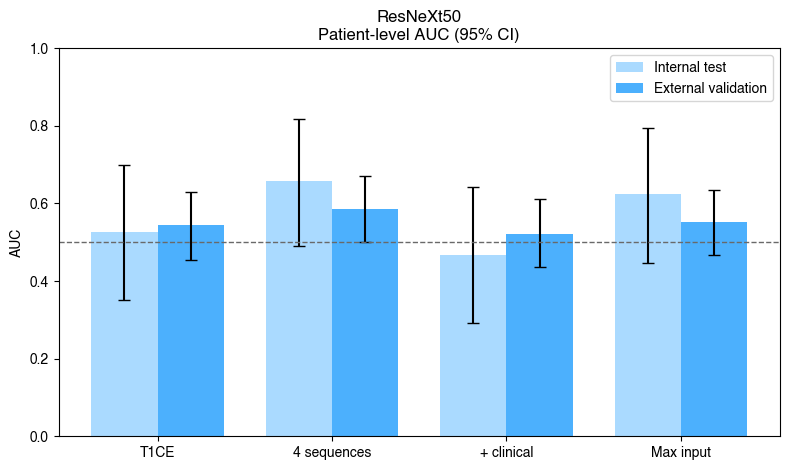

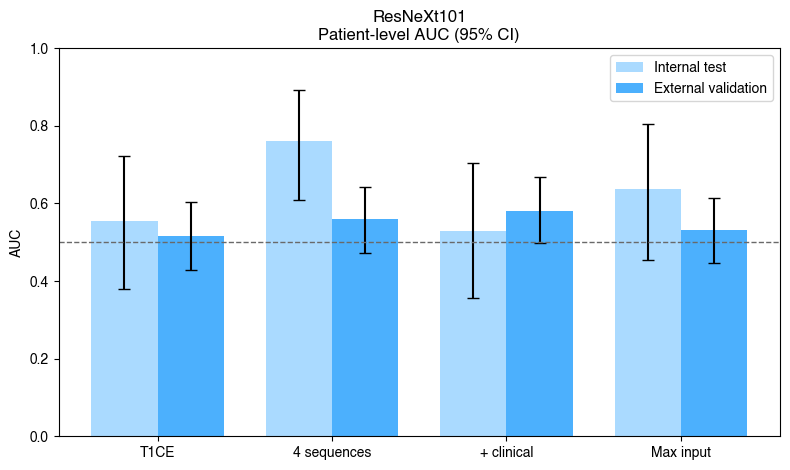

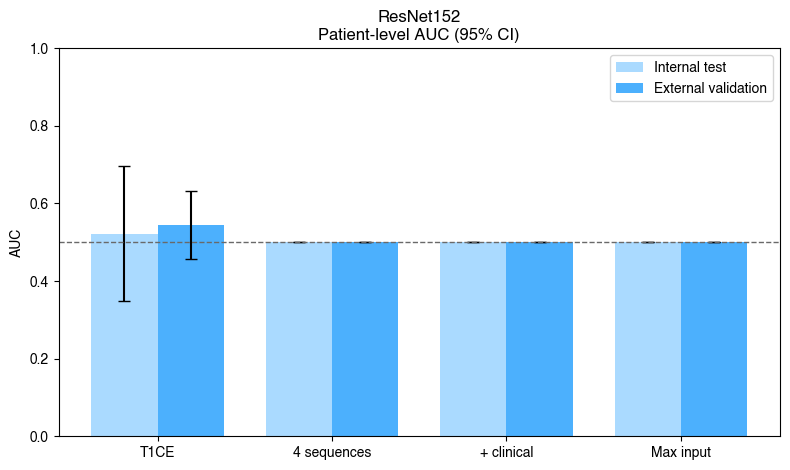

,arch,variant,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,T1CE,0.527244,0.350954,0.698658,"0.527 [0.351, 0.699]",0.543578,0.455372,0.629167,"0.544 [0.455, 0.629]"
1,ResNeXt50,4 sequences,0.657692,0.489239,0.817619,"0.658 [0.489, 0.818]",0.585770,0.499348,0.669321,"0.586 [0.499, 0.669]"
2,ResNeXt50,+ clinical,0.466346,0.291667,0.642045,"0.466 [0.292, 0.642]",0.521767,0.437218,0.610590,"0.522 [0.437, 0.611]"
3,ResNeXt50,Max input,0.625000,0.445807,0.795220,"0.625 [0.446, 0.795]",0.552956,0.465846,0.634774,"0.553 [0.466, 0.635]"
4,ResNeXt101,T1CE,0.555128,0.379424,0.721829,"0.555 [0.379, 0.722]",0.517132,0.428118,0.602683,"0.517 [0.428, 0.603]"
5,ResNeXt101,4 sequences,0.760577,0.608120,0.891819,"0.761 [0.608, 0.892]",0.559844,0.472059,0.641034,"0.560 [0.472, 0.641]"
6,ResNeXt101,+ clinical,0.529808,0.357095,0.703831,"0.530 [0.357, 0.704]",0.580247,0.499153,0.667039,"0.580 [0.499, 0.667]"
7,ResNeXt101,Max input,0.636538,0.455207,0.805772,"0.637 [0.455, 0.806]",0.531124,0.445189,0.614525,"0.531 [0.445, 0.615]"
8,ResNet152,T1CE,0.522436,0.348843,0.696387,"0.522 [0.349, 0.696]",0.544141,0.456461,0.632021,"0.544 [0.456, 0.632]"
9,ResNet152,4 sequences,0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]",0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]"


,arch,variant,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,T1CE,0.527244,0.350954,0.698658,"0.527 [0.351, 0.699]",0.543578,0.455372,0.629167,"0.544 [0.455, 0.629]"
1,ResNeXt50,4 sequences,0.657692,0.489239,0.817619,"0.658 [0.489, 0.818]",0.585770,0.499348,0.669321,"0.586 [0.499, 0.669]"
2,ResNeXt50,+ clinical,0.466346,0.291667,0.642045,"0.466 [0.292, 0.642]",0.521767,0.437218,0.610590,"0.522 [0.437, 0.611]"
3,ResNeXt50,Max input,0.625000,0.445807,0.795220,"0.625 [0.446, 0.795]",0.552956,0.465846,0.634774,"0.553 [0.466, 0.635]"
4,ResNeXt101,T1CE,0.555128,0.379424,0.721829,"0.555 [0.379, 0.722]",0.517132,0.428118,0.602683,"0.517 [0.428, 0.603]"
5,ResNeXt101,4 sequences,0.760577,0.608120,0.891819,"0.761 [0.608, 0.892]",0.559844,0.472059,0.641034,"0.560 [0.472, 0.641]"
6,ResNeXt101,+ clinical,0.529808,0.357095,0.703831,"0.530 [0.357, 0.704]",0.580247,0.499153,0.667039,"0.580 [0.499, 0.667]"
7,ResNeXt101,Max input,0.636538,0.455207,0.805772,"0.637 [0.455, 0.806]",0.531124,0.445189,0.614525,"0.531 [0.445, 0.615]"
8,ResNet152,T1CE,0.522436,0.348843,0.696387,"0.522 [0.349, 0.696]",0.544141,0.456461,0.632021,"0.544 [0.456, 0.632]"
9,ResNet152,4 sequences,0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]",0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]"


In [59]:
variant_order = ["t1c", "4 seq", "clinical", "max_info"]

variant_label_map = {
    "t1c": "T1CE",
    "4 seq": "4 sequences",
    "clinical": "+ clinical",
    "max_info": "Max input",
}

arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]
plot_grouped_auc_with_table(
    df_ci=df_ci,
    archs=arch_order,
    category_col="variant",
    category_order=variant_order,
    merge_archs=False,
    category_label_map=variant_label_map,
    per_panel_title_fmt="{arch}\nPatient-level AUC (95% CI)",
    decimals=3,
)

### combined graphs

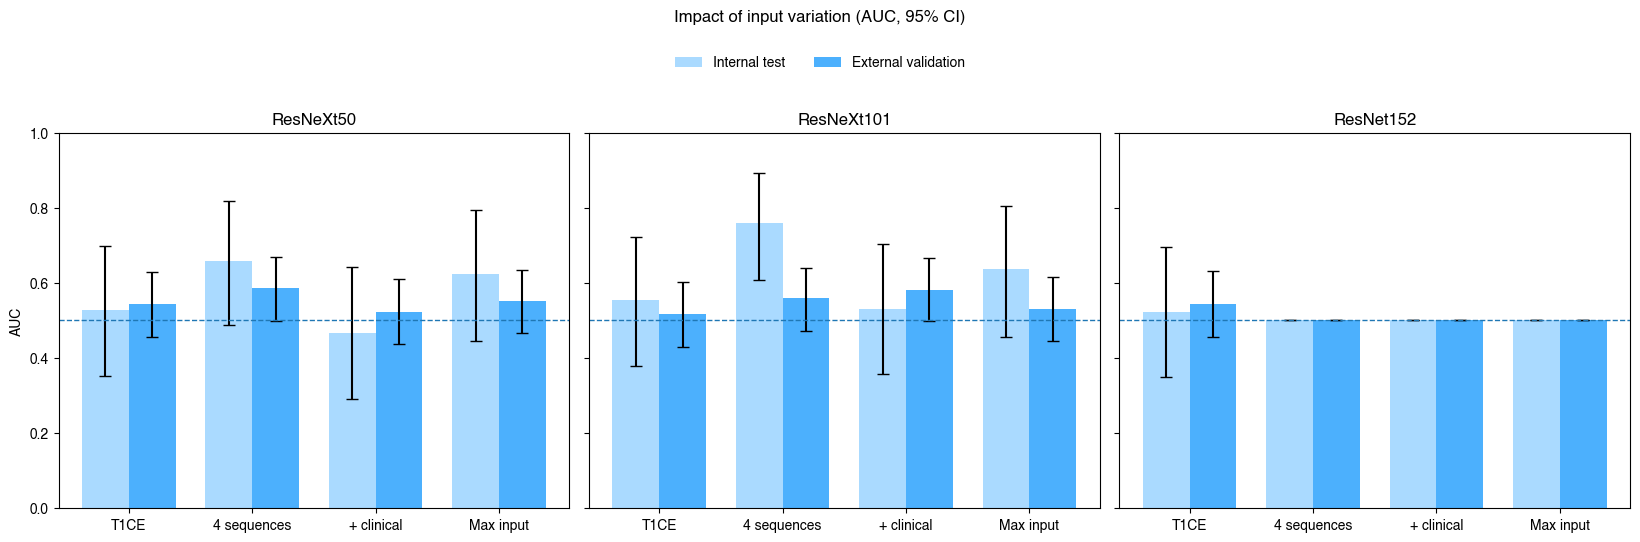

,arch,variant,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,T1CE,0.527244,0.350954,0.698658,"0.527 [0.351, 0.699]",0.543578,0.455372,0.629167,"0.544 [0.455, 0.629]"
1,ResNeXt50,4 sequences,0.657692,0.489239,0.817619,"0.658 [0.489, 0.818]",0.585770,0.499348,0.669321,"0.586 [0.499, 0.669]"
2,ResNeXt50,+ clinical,0.466346,0.291667,0.642045,"0.466 [0.292, 0.642]",0.521767,0.437218,0.610590,"0.522 [0.437, 0.611]"
3,ResNeXt50,Max input,0.625000,0.445807,0.795220,"0.625 [0.446, 0.795]",0.552956,0.465846,0.634774,"0.553 [0.466, 0.635]"
4,ResNeXt101,T1CE,0.555128,0.379424,0.721829,"0.555 [0.379, 0.722]",0.517132,0.428118,0.602683,"0.517 [0.428, 0.603]"
5,ResNeXt101,4 sequences,0.760577,0.608120,0.891819,"0.761 [0.608, 0.892]",0.559844,0.472059,0.641034,"0.560 [0.472, 0.641]"
6,ResNeXt101,+ clinical,0.529808,0.357095,0.703831,"0.530 [0.357, 0.704]",0.580247,0.499153,0.667039,"0.580 [0.499, 0.667]"
7,ResNeXt101,Max input,0.636538,0.455207,0.805772,"0.637 [0.455, 0.806]",0.531124,0.445189,0.614525,"0.531 [0.445, 0.615]"
8,ResNet152,T1CE,0.522436,0.348843,0.696387,"0.522 [0.349, 0.696]",0.544141,0.456461,0.632021,"0.544 [0.456, 0.632]"
9,ResNet152,4 sequences,0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]",0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]"


,arch,variant,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,T1CE,0.527244,0.350954,0.698658,"0.527 [0.351, 0.699]",0.543578,0.455372,0.629167,"0.544 [0.455, 0.629]"
1,ResNeXt50,4 sequences,0.657692,0.489239,0.817619,"0.658 [0.489, 0.818]",0.585770,0.499348,0.669321,"0.586 [0.499, 0.669]"
2,ResNeXt50,+ clinical,0.466346,0.291667,0.642045,"0.466 [0.292, 0.642]",0.521767,0.437218,0.610590,"0.522 [0.437, 0.611]"
3,ResNeXt50,Max input,0.625000,0.445807,0.795220,"0.625 [0.446, 0.795]",0.552956,0.465846,0.634774,"0.553 [0.466, 0.635]"
4,ResNeXt101,T1CE,0.555128,0.379424,0.721829,"0.555 [0.379, 0.722]",0.517132,0.428118,0.602683,"0.517 [0.428, 0.603]"
5,ResNeXt101,4 sequences,0.760577,0.608120,0.891819,"0.761 [0.608, 0.892]",0.559844,0.472059,0.641034,"0.560 [0.472, 0.641]"
6,ResNeXt101,+ clinical,0.529808,0.357095,0.703831,"0.530 [0.357, 0.704]",0.580247,0.499153,0.667039,"0.580 [0.499, 0.667]"
7,ResNeXt101,Max input,0.636538,0.455207,0.805772,"0.637 [0.455, 0.806]",0.531124,0.445189,0.614525,"0.531 [0.445, 0.615]"
8,ResNet152,T1CE,0.522436,0.348843,0.696387,"0.522 [0.349, 0.696]",0.544141,0.456461,0.632021,"0.544 [0.456, 0.632]"
9,ResNet152,4 sequences,0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]",0.500000,0.500000,0.500000,"0.500 [0.500, 0.500]"


In [50]:
arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]

plot_grouped_auc_with_table(
    df_ci=df_ci,
    archs=arch_order,
    category_col="variant",
    category_order=variant_order,
    category_label_map=variant_label_map,
    merge_archs=True,
    table_mode="combined",  # or "per_panel" or "none"
    suptitle="Impact of input variation (AUC, 95% CI)"
)

## Pretraining variation graphs
### separate graphs

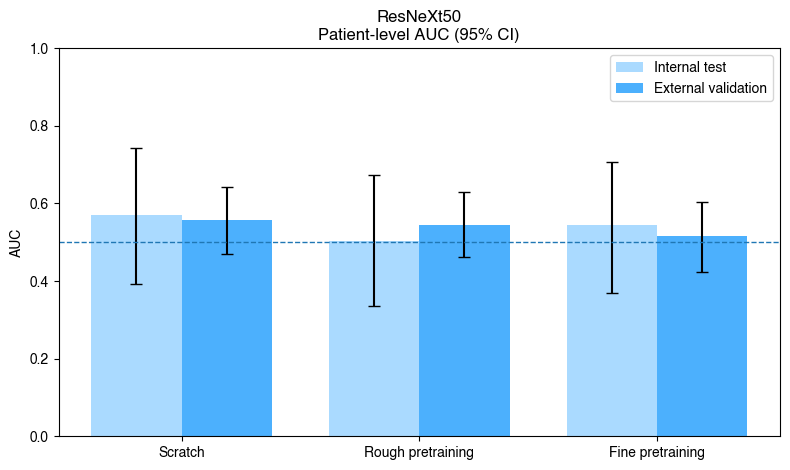

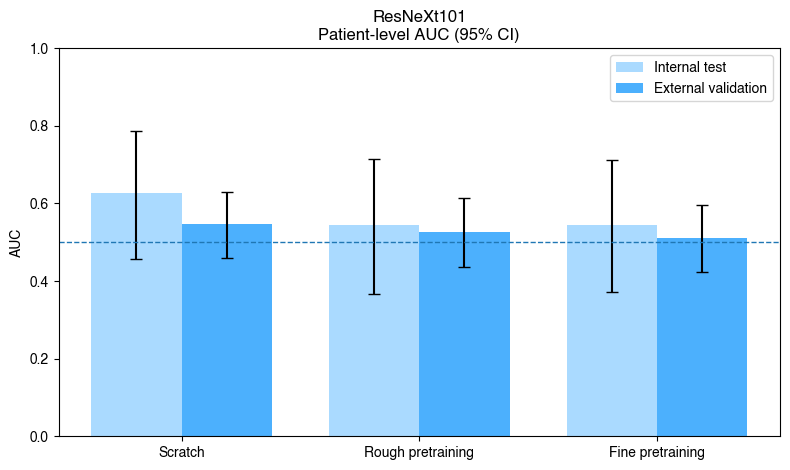

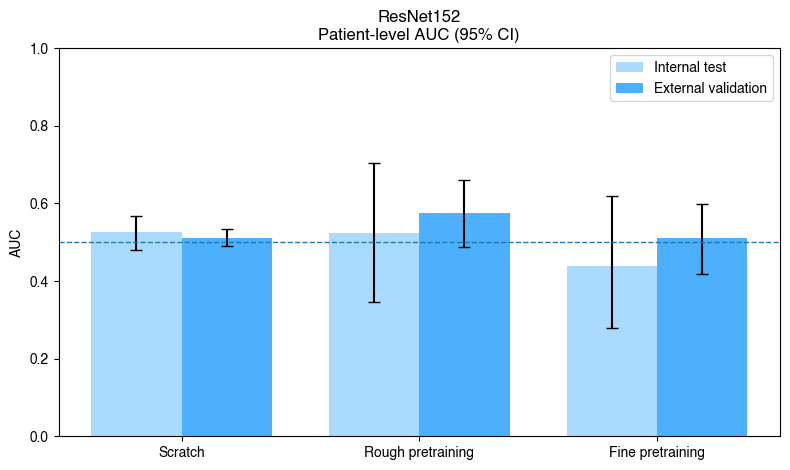

,arch,strategy,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,Scratch,0.570913,0.393503,0.742601,"0.571 [0.394, 0.743]",0.557554,0.470272,0.642528,"0.558 [0.470, 0.643]"
1,ResNeXt50,Rough pretraining,0.503846,0.335200,0.673508,"0.504 [0.335, 0.674]",0.545549,0.462977,0.628483,"0.546 [0.463, 0.628]"
2,ResNeXt50,Fine pretraining,0.543269,0.370362,0.706946,"0.543 [0.370, 0.707]",0.515465,0.424463,0.603592,"0.515 [0.424, 0.604]"
3,ResNeXt101,Scratch,0.625962,0.455526,0.785488,"0.626 [0.456, 0.785]",0.546345,0.459995,0.630180,"0.546 [0.460, 0.630]"
4,ResNeXt101,Rough pretraining,0.544231,0.366054,0.713117,"0.544 [0.366, 0.713]",0.526446,0.437035,0.614857,"0.526 [0.437, 0.615]"
5,ResNeXt101,Fine pretraining,0.544231,0.370535,0.711840,"0.544 [0.371, 0.712]",0.510786,0.423741,0.595068,"0.511 [0.424, 0.595]"
6,ResNet152,Scratch,0.525721,0.480342,0.566971,"0.526 [0.480, 0.567]",0.511940,0.490559,0.534336,"0.512 [0.491, 0.534]"
7,ResNet152,Rough pretraining,0.525000,0.345025,0.703177,"0.525 [0.345, 0.703]",0.574399,0.488703,0.660909,"0.574 [0.489, 0.661]"
8,ResNet152,Fine pretraining,0.439423,0.280134,0.618100,"0.439 [0.280, 0.618]",0.510266,0.418442,0.597810,"0.510 [0.418, 0.598]"


,arch,strategy,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,Scratch,0.570913,0.393503,0.742601,"0.571 [0.394, 0.743]",0.557554,0.470272,0.642528,"0.558 [0.470, 0.643]"
1,ResNeXt50,Rough pretraining,0.503846,0.335200,0.673508,"0.504 [0.335, 0.674]",0.545549,0.462977,0.628483,"0.546 [0.463, 0.628]"
2,ResNeXt50,Fine pretraining,0.543269,0.370362,0.706946,"0.543 [0.370, 0.707]",0.515465,0.424463,0.603592,"0.515 [0.424, 0.604]"
3,ResNeXt101,Scratch,0.625962,0.455526,0.785488,"0.626 [0.456, 0.785]",0.546345,0.459995,0.630180,"0.546 [0.460, 0.630]"
4,ResNeXt101,Rough pretraining,0.544231,0.366054,0.713117,"0.544 [0.366, 0.713]",0.526446,0.437035,0.614857,"0.526 [0.437, 0.615]"
5,ResNeXt101,Fine pretraining,0.544231,0.370535,0.711840,"0.544 [0.371, 0.712]",0.510786,0.423741,0.595068,"0.511 [0.424, 0.595]"
6,ResNet152,Scratch,0.525721,0.480342,0.566971,"0.526 [0.480, 0.567]",0.511940,0.490559,0.534336,"0.512 [0.491, 0.534]"
7,ResNet152,Rough pretraining,0.525000,0.345025,0.703177,"0.525 [0.345, 0.703]",0.574399,0.488703,0.660909,"0.574 [0.489, 0.661]"
8,ResNet152,Fine pretraining,0.439423,0.280134,0.618100,"0.439 [0.280, 0.618]",0.510266,0.418442,0.597810,"0.510 [0.418, 0.598]"


In [54]:
strategy_order = ["scratch", "rough", "fine"]

strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

# If you want to restrict pretraining comparison to T1c only (recommended if that's how you trained it):
# df_ci_t1c = df_ci[df_ci["variant"] == "t1c"].copy()
df_ci_t1c = df_ci  # keep as-is unless you want strict t1c-only comparison

arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]
plot_grouped_auc_with_table(
    df_ci=df_ci_t1c,
    archs=arch_order,
    category_col="strategy",
    merge_archs=False,
    category_order=strategy_order,
    category_label_map=strategy_label_map,
    per_panel_title_fmt="{arch}\nPatient-level AUC (95% CI)",
    decimals=3,
)

### combined graphs

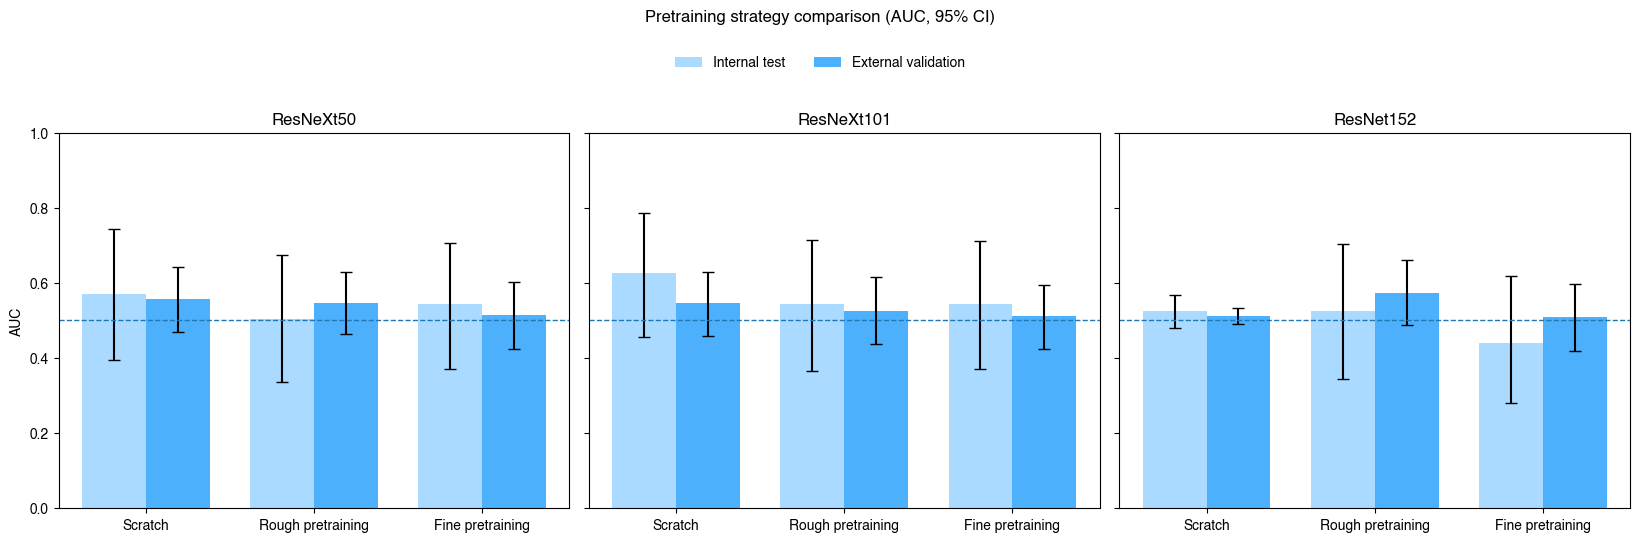

,arch,strategy,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,Scratch,0.570913,0.393503,0.742601,"0.571 [0.394, 0.743]",0.557554,0.470272,0.642528,"0.558 [0.470, 0.643]"
1,ResNeXt50,Rough pretraining,0.503846,0.335200,0.673508,"0.504 [0.335, 0.674]",0.545549,0.462977,0.628483,"0.546 [0.463, 0.628]"
2,ResNeXt50,Fine pretraining,0.543269,0.370362,0.706946,"0.543 [0.370, 0.707]",0.515465,0.424463,0.603592,"0.515 [0.424, 0.604]"
3,ResNeXt101,Scratch,0.625962,0.455526,0.785488,"0.626 [0.456, 0.785]",0.546345,0.459995,0.630180,"0.546 [0.460, 0.630]"
4,ResNeXt101,Rough pretraining,0.544231,0.366054,0.713117,"0.544 [0.366, 0.713]",0.526446,0.437035,0.614857,"0.526 [0.437, 0.615]"
5,ResNeXt101,Fine pretraining,0.544231,0.370535,0.711840,"0.544 [0.371, 0.712]",0.510786,0.423741,0.595068,"0.511 [0.424, 0.595]"
6,ResNet152,Scratch,0.525721,0.480342,0.566971,"0.526 [0.480, 0.567]",0.511940,0.490559,0.534336,"0.512 [0.491, 0.534]"
7,ResNet152,Rough pretraining,0.525000,0.345025,0.703177,"0.525 [0.345, 0.703]",0.574399,0.488703,0.660909,"0.574 [0.489, 0.661]"
8,ResNet152,Fine pretraining,0.439423,0.280134,0.618100,"0.439 [0.280, 0.618]",0.510266,0.418442,0.597810,"0.510 [0.418, 0.598]"


,arch,strategy,internal_auc,internal_auc_ci_low,internal_auc_ci_high,internal_auc_ci,external_auc,external_auc_ci_low,external_auc_ci_high,external_auc_ci
0,ResNeXt50,Scratch,0.570913,0.393503,0.742601,"0.571 [0.394, 0.743]",0.557554,0.470272,0.642528,"0.558 [0.470, 0.643]"
1,ResNeXt50,Rough pretraining,0.503846,0.335200,0.673508,"0.504 [0.335, 0.674]",0.545549,0.462977,0.628483,"0.546 [0.463, 0.628]"
2,ResNeXt50,Fine pretraining,0.543269,0.370362,0.706946,"0.543 [0.370, 0.707]",0.515465,0.424463,0.603592,"0.515 [0.424, 0.604]"
3,ResNeXt101,Scratch,0.625962,0.455526,0.785488,"0.626 [0.456, 0.785]",0.546345,0.459995,0.630180,"0.546 [0.460, 0.630]"
4,ResNeXt101,Rough pretraining,0.544231,0.366054,0.713117,"0.544 [0.366, 0.713]",0.526446,0.437035,0.614857,"0.526 [0.437, 0.615]"
5,ResNeXt101,Fine pretraining,0.544231,0.370535,0.711840,"0.544 [0.371, 0.712]",0.510786,0.423741,0.595068,"0.511 [0.424, 0.595]"
6,ResNet152,Scratch,0.525721,0.480342,0.566971,"0.526 [0.480, 0.567]",0.511940,0.490559,0.534336,"0.512 [0.491, 0.534]"
7,ResNet152,Rough pretraining,0.525000,0.345025,0.703177,"0.525 [0.345, 0.703]",0.574399,0.488703,0.660909,"0.574 [0.489, 0.661]"
8,ResNet152,Fine pretraining,0.439423,0.280134,0.618100,"0.439 [0.280, 0.618]",0.510266,0.418442,0.597810,"0.510 [0.418, 0.598]"


In [55]:
strategy_order = ["scratch", "rough", "fine"]
strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

plot_grouped_auc_with_table(
    df_ci=df_ci,
    archs=arch_order,
    category_col="strategy",
    category_order=strategy_order,
    category_label_map=strategy_label_map,
    merge_archs=True,
    table_mode="combined",
    suptitle="Pretraining strategy comparison (AUC, 95% CI)"
)

# Lesion Level CI
## Input Variation Plots
### separate graphs

### combined graphs

## Pretraining variation graphs
### separate graphs

### combined graphs